# How to Process Audio on Your GPU with TensorFlow

This is the complimentary notebook to my [Medium post](https://bit.ly/2UaNKQp) with the same name.

You can read the post by [clicking here](https://bit.ly/2UaNKQp).

The purpose of this notebook is to present the code in an interactive way, so it's easy for you to follow along, change things, play around and make it your own.

This also means, I'll leave out any in-depth explanations from this notebook. You'll find those in [the original post](https://bit.ly/2UaNKQp).

Please enjoy.

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
import unittest
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from IPython.display import Audio

import librosa.display
import librosa as lr
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
_SAMPLE_RATE = 16000

In [ ]:
# Load NSynth's test split as a tf.data.Dataset
ds = tfds.load(name='nsynth/full', 
               split=tfds.Split.TEST, 
               try_gcs=True)

# Build a simple data pipeline
ds = ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

Want to know more about [building efficient data-pipelines for audio data with TensorFlow](https://towardsdatascience.com/how-to-build-efficient-audio-data-pipelines-with-tensorflow-2-0-b3133474c3c1)? Check out [my post](https://towardsdatascience.com/how-to-build-efficient-audio-data-pipelines-with-tensorflow-2-0-b3133474c3c1) on this subject.

In [ ]:
# Get first batch's audio 
batch = next(iter(ds))
audio = batch['audio']

In [ ]:
_ID = 7  # Pick the 7th sound in this batch as example
Audio(audio[_ID].numpy(), rate=_SAMPLE_RATE)

## From audio to mel-spectrogram in 5 simple steps

1. Compute the [short-time Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) of your audio signals
2. Discard the phase and keep the magnitude
3. Instantiate the mel filterbank
4. Warp the linear-scale magnitude-spectrograms to mel-scale
5. Transform magnitudes to log-scale


### A few constants we'll need shortly

In [ ]:
_FFT_SIZE = 1024
_HOP_SIZE = 512
_N_MEL_BINS = 64
_N_SPECTROGRAM_BINS = (_FFT_SIZE // 2) + 1
_F_MIN = 0.0
_F_MAX = _SAMPLE_RATE / 2

### 1. Compute the short-time Fourier transform of your audio signals

In [ ]:
spectrograms = tf.signal.stft(audio, 
                              frame_length=_FFT_SIZE, 
                              frame_step=_HOP_SIZE)

### 2. Compute the magnitude



In [ ]:
magnitude_spectrograms = tf.abs(spectrograms)

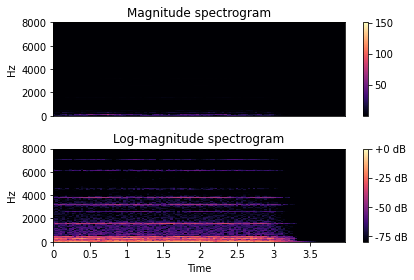

In [ ]:
# https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html

S = magnitude_spectrograms[_ID].numpy().T

plt.figure()
plt.subplot(2, 1, 1)
lr.display.specshow(S, sr=_SAMPLE_RATE, y_axis='linear')
plt.colorbar()
plt.title('Magnitude spectrogram')

plt.subplot(2, 1, 2)
lr.display.specshow(lr.amplitude_to_db(S, ref=np.max),
                    y_axis='linear', x_axis='time', sr=_SAMPLE_RATE, 
                    hop_length=_HOP_SIZE)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-magnitude spectrogram')
plt.tight_layout()
_ = plt.savefig('magspec.png', dpi=300)

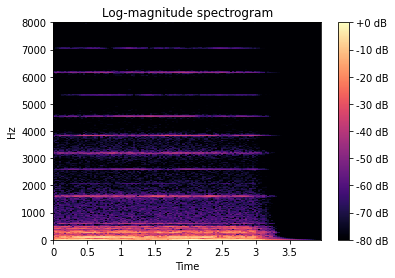

In [ ]:
lr.display.specshow(lr.amplitude_to_db(S, ref=np.max), 
                    y_axis='linear', x_axis='time', sr=_SAMPLE_RATE, 
                    hop_length=_HOP_SIZE)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-magnitude spectrogram');

### 3. Instantiate the mel filterbank

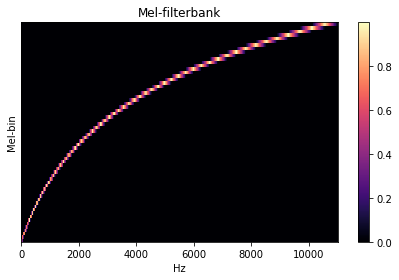

In [ ]:
mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=_N_MEL_BINS,
    num_spectrogram_bins=_N_SPECTROGRAM_BINS,
    sample_rate=_SAMPLE_RATE,
    lower_edge_hertz=_F_MIN,
    upper_edge_hertz=_F_MAX)


plt.figure()
lr.display.specshow(mel_filterbank.numpy().T, x_axis='linear')
plt.ylabel('Mel-bin')
plt.title('Mel-filterbank')
plt.colorbar()
plt.tight_layout()
_ = plt.savefig('filterbank.png', dpi=300)

### 4. Warp the linear-scaled magnitude spectrograms to mel scale

In [ ]:
mel_power_spectrograms = tf.matmul(tf.square(magnitude_spectrograms),
                                   mel_filterbank)

### 5. Transform magnitudes to log-scale

In [ ]:
def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.

    Computes the scaling ``10 * log10(S / max(S))`` in a numerically
    stable way.

    Based on:

    https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S. Zeros in the output 
    # correspond to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec


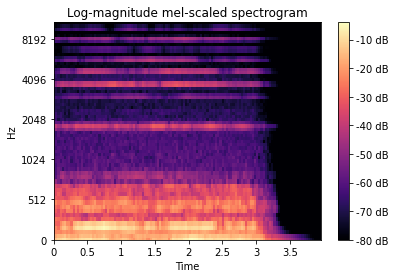

In [ ]:
log_magnitude_mel_spectrograms = power_to_db(mel_power_spectrograms)

lr.display.specshow(log_magnitude_mel_spectrograms[_ID].numpy().T, 
                    y_axis='mel', x_axis='time', sr=_SAMPLE_RATE, 
                    hop_length=_HOP_SIZE)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-magnitude mel-scaled spectrogram')
_ = plt.savefig('melspec.png', dpi=300)

## Defining your custom preprocessing layer

In [ ]:
class LogMelSpectrogram(tf.keras.layers.Layer):
    """Compute log-magnitude mel-scaled spectrograms."""

    def __init__(self, sample_rate, fft_size, hop_size, n_mels,
                 f_min=0.0, f_max=None, **kwargs):
        super(LogMelSpectrogram, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.fft_size = fft_size
        self.hop_size = hop_size
        self.n_mels = n_mels
        self.f_min = f_min
        self.f_max = f_max if f_max else sample_rate / 2
        self.mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=self.n_mels,
            num_spectrogram_bins=fft_size // 2 + 1,
            sample_rate=self.sample_rate,
            lower_edge_hertz=self.f_min,
            upper_edge_hertz=self.f_max)

    def build(self, input_shape):
        self.non_trainable_weights.append(self.mel_filterbank)
        super(LogMelSpectrogram, self).build(input_shape)

    def call(self, waveforms):
        """Forward pass.

        Parameters
        ----------
        waveforms : tf.Tensor, shape = (None, n_samples)
            A Batch of mono waveforms.

        Returns
        -------
        log_mel_spectrograms : (tf.Tensor), shape = (None, time, freq, ch)
            The corresponding batch of log-mel-spectrograms
        """
        def _tf_log10(x):
            numerator = tf.math.log(x)
            denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
            return numerator / denominator

        def power_to_db(magnitude, amin=1e-16, top_db=80.0):
            """
            https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
            """
            ref_value = tf.reduce_max(magnitude)
            log_spec = 10.0 * _tf_log10(tf.maximum(amin, magnitude))
            log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref_value))
            log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

            return log_spec

        spectrograms = tf.signal.stft(waveforms,
                                      frame_length=self.fft_size,
                                      frame_step=self.hop_size,
                                      pad_end=False)

        magnitude_spectrograms = tf.abs(spectrograms)

        mel_spectrograms = tf.matmul(tf.square(magnitude_spectrograms),
                                     self.mel_filterbank)

        log_mel_spectrograms = power_to_db(mel_spectrograms)

        # add channel dimension
        log_mel_spectrograms = tf.expand_dims(log_mel_spectrograms, 3)

        return log_mel_spectrograms

    def get_config(self):
        config = {
            'fft_size': self.fft_size,
            'hop_size': self.hop_size,
            'n_mels': self.n_mels,
            'sample_rate': self.sample_rate,
            'f_min': self.f_min,
            'f_max': self.f_max,
        }
        config.update(super(LogMelSpectrogram, self).get_config())

        return config


## Testing your custom preprocessing layer

In [ ]:
class TestLogMelSpectrogram(tf.test.TestCase):

    sample_rate = _SAMPLE_RATE
    fft_size = _FFT_SIZE
    hop_size = _HOP_SIZE
    n_mels = _N_MEL_BINS
    f_min = _F_MIN
    f_max = _F_MAX

    def setUp(self):
        self.mel_layer = LogMelSpectrogram(sample_rate=self.sample_rate,
                                           fft_size=self.fft_size,
                                           hop_size=self.hop_size,
                                           n_mels=self.n_mels)
        np.random.seed(42)
        self.audio = np.random.rand(1, self.sample_rate).astype(np.float32)

    def test_returns_tensor_with_four_dimensions(self):
        tensor_shape = self.mel_layer(audio).shape
        self.assertEqual(len(tensor_shape), 4)

    def test_returns_tensor_with_correct_shape(self):
        batch_size = 32
        src = np.random.randn(batch_size, self.sample_rate).astype(np.float32)
        batch_items, frames, mel_bins, channels = self.mel_layer(src).shape

        self.assertEqual(batch_items, batch_size)
        self.assertEqual(frames, np.ceil((self.sample_rate - self.fft_size)
                                          / self.hop_size))
        self.assertEqual(mel_bins, self.n_mels)
        self.assertEqual(channels, 1)

    def test_is_close_to_librosa_melgram(self):
        src = np.random.randn(self.sample_rate).astype(np.float32)
        tf_log_mel_spectrogram = self.mel_layer(src.reshape(1, -1))
        # pick first (and only) batch item and remove channel dimension
        tf_log_mel_spectrogram = tf_log_mel_spectrogram[0, :, :, 0]

        lr_mag_specgram = np.abs(lr.stft(y=src,
                                         n_fft=self.fft_size,
                                         hop_length=self.hop_size,
                                         center=False,
                                         win_length=self.fft_size))

        mel_filterbank = lr.filters.mel(sr=self.sample_rate,
                                        n_fft=self.fft_size,
                                        n_mels=self.n_mels,
                                        fmin=self.f_min,
                                        fmax=self.f_max,
                                        htk=True,
                                        norm=None).astype(np.float32())

        lr_mel_spectrogram = np.dot(lr_mag_specgram.T ** 2, mel_filterbank.T)
        lr_log_mel_spectrogram = lr.power_to_db(lr_mel_spectrogram, ref=np.max,
                                                amin=1e-16)

        self.assertEqual(tf_log_mel_spectrogram.shape, 
                         lr_log_mel_spectrogram.shape)
        
        self.assertAllClose(tf_log_mel_spectrogram, lr_log_mel_spectrogram,
                            rtol=1e-2, atol=1e-2)

_ = unittest.main(argv=['first-arg-is-ignored'], exit=False)

...

Instructions for updating:
Use `self.session()` or `self.cached_session()` instead.


Instructions for updating:
Use `self.session()` or `self.cached_session()` instead.
.
----------------------------------------------------------------------
Ran 4 tests in 0.712s

OK


## Using your custom preprocessing layer

In [ ]:
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Dropout, Flatten, Input, MaxPool2D)
from tensorflow.keras.models import Model

In [ ]:
def ConvModel(n_classes, sample_rate=16000, duration=4,
              fft_size=_FFT_SIZE, hop_size=_HOP_SIZE, n_mels=_N_MEL_BINS):
    n_samples = sample_rate * duration
    input_shape = (n_samples,)

    x = Input(shape=input_shape, name='input', dtype='float32')    
    y = LogMelSpectrogram(sample_rate, fft_size, hop_size, n_mels)(x)
    
    # data normalization (on frequency axis)
    y = BatchNormalization(axis=2)(y)
    
    # effectively 1D convolution, since kernel spans entire frequency-axis
    y = Conv2D(32, (3, n_mels), activation='relu')(y)
    y = BatchNormalization()(y)
    y = MaxPool2D((1, y.shape[2]))(y)

    y = Conv2D(32, (3, 1), activation='relu')(y)
    y = BatchNormalization()(y)
    y = MaxPool2D(pool_size=(2, 1))(y)

    y = Flatten()(y)
    y = Dense(64, activation='relu')(y)
    y = Dropout(0.25)(y)
    y = Dense(n_classes, activation='softmax')(y)

    return Model(inputs=x, outputs=y)


In [ ]:
model = ConvModel(11)
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64000)]           0         
_________________________________________________________________
log_mel_spectrogram_4 (LogMe (None, 124, 64, 1)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 64, 1)        256       
_________________________________________________________________
conv2d (Conv2D)              (None, 122, 1, 32)        6176      
_________________________________________________________________
batch_normalization_1 (Batch (None, 122, 1, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 1, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 1, 32)        3104  

In [ ]:
# Load NSynth's test split as a tf.data.Dataset
# https://www.tensorflow.org/datasets/catalog/nsynth
ds = tfds.load(name='nsynth/full', 
               split=tfds.Split.TEST, 
               try_gcs=True)

_DS_SIZE = 4096  # From documentation
_EPOCHS = 20
_BATCH_SIZE = 256
_STEPS = _DS_SIZE / _BATCH_SIZE

# Let's train a model to predict the instrument family from audio
# https://magenta.tensorflow.org/datasets/nsynth#instrument-families
ds = ds.map(lambda x: (x['audio'], x['instrument']['family']))

# Build your input pipeline
train_ds = (ds.batch(_BATCH_SIZE)
              .prefetch(tf.data.experimental.AUTOTUNE)
              .repeat())

In [ ]:
model.fit(train_ds, epochs=_EPOCHS, steps_per_epoch=_STEPS)

Train for 16.0 steps
Epoch 1/20
16/16 [==============================] - 67s 4s/step - loss: 1.8955 - sparse_categorical_accuracy: 0.3943
Epoch 2/20
16/16 [==============================] - 64s 4s/step - loss: 1.0320 - sparse_categorical_accuracy: 0.6421
Epoch 3/20
16/16 [==============================] - 64s 4s/step - loss: 0.7288 - sparse_categorical_accuracy: 0.7466
Epoch 4/20
16/16 [==============================] - 64s 4s/step - loss: 0.5340 - sparse_categorical_accuracy: 0.8162
Epoch 5/20
16/16 [==============================] - 64s 4s/step - loss: 0.3979 - sparse_categorical_accuracy: 0.8711
Epoch 6/20
16/16 [==============================] - 63s 4s/step - loss: 0.3181 - sparse_categorical_accuracy: 0.8992
Epoch 7/20
16/16 [==============================] - 64s 4s/step - loss: 0.2490 - sparse_categorical_accuracy: 0.9238
Epoch 8/20
 9/16 [===============>..............] - ETA: 26s - loss: 0.2024 - sparse_categorical_accuracy: 0.9427

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
  IN_COLAB = False